# Project: Perception on Public Security in the United States of Mexico

## Introduction

After a recent trip to Mexico, I decided to explore the website of the National Institute of Statistics and Geography of Mexico ([INEGI](https://en.www.inegi.org.mx/default.html)) and use this project as an opportunity to learn more about the country. 

After exploring the data available on the website, I decided to investigate the issue of security, particalarly perceived security, within the country. I chose this topic for 2 main reasons: 

1) While planning my trip, I was surprised of the concern expressed by my Mexican friends (both male and female). Also, during my trip, I noticed that my own perception of security (or lack thereof) was different, based on the city/town I was visiting. 

2) The data available on the INEGI website looks complex, and interesting enough to investigate: the survey has been iterated for a number of years (yearly, from 2010 to 2025), and it's divided by state, which allows both a temporal and a geographic analysis. 

### Project scope

The goal of this project is to investigate the following points: 

- How does perception of public security in Mexico change, based on the state? 

- Has it changed, overall, in the past 15 years? 

- What are the main concerns that affect perceived security (or lack of it)? 

## 1. Data import

All the packages required for the project are imported.

In [1]:
import pandas as pd
import requests 
import openpyxl
import seaborn as sns
import matplotlib.pyplot as plt

### API requests and download

After exploring the webiste of INEGI, I found 2 ways of sourcing public data: 

- using the API 
- dowloading the data i .xlsx format. 

I explored both ways. 

**API requests**

The API requires a token (or key), which can be requested for free by registering with an email address. The API requests can be created using a [Query Builder](https://en.www.inegi.org.mx/servicios/api_indicadores.html) that inputs parameters such as: 

- indicator,
- geographic area,
- language (Spanish or English).

The [documentation](https://en.www.inegi.org.mx/servicios/api_indicadores.html) is quite clear and accessible, and available in Spanish and English.

However, the API has some limitations:

1. it returns responses in .json, .jsonp, or .xml, which make it hard to read and manipulate the data with Pandas (see below);
2. it only allows to request data about one area at the time, which does not allow to compare data points across regions;
3. it allows to input max 10 indicators per request, which returns a partial dataset and limits analysis.

In [2]:
# code provided by chatGPT: https://chatgpt.com/share/6950450b-d294-800f-8cb4-c585e1a7fe7f

# 1. Fetch the JSON from the API
url = "https://en.www.inegi.org.mx/app/api/indicadores/desarrolladores/jsonxml/INDICATOR/6200028417,6200028418,6200028419,6200028420,6200028431,6200028430,6200028427,6200028425,6200028423,6200028433/en/00,01/true/BISE/2.0/0f18317c-23e8-90bd-c373-f2e07a38e907?type=json"
response = requests.get(url)
data = response.json()  # Convert response to Python dict

# 2. Create a DataFrame from the "Series" list
series_df = pd.json_normalize(data["Series"])

# 3. Also flatten the "OBSERVATIONS" nested list
obs_df = pd.json_normalize(
    data["Series"],
    record_path=["OBSERVATIONS"],
    meta=["INDICADOR"],
    errors="ignore"
)

# 4. Merge Series-level with Observations
df = series_df.drop(columns=["OBSERVATIONS"]).merge(
    obs_df,
    on="INDICADOR",
    how="inner"
)

# preview data 
df.head(5)

,INDICADOR,FREQ,TOPIC,UNIT,UNIT_MULT,NOTE,SOURCE,LASTUPDATE,STATUS,TIME_PERIOD,OBS_VALUE,OBS_EXCEPTION,OBS_STATUS,OBS_SOURCE,OBS_NOTE,COBER_GEO
0,6200028417,3,163,3,,,"1024,1027,1054,1171,1795,2196,2782,2822,2928,2...",18/09/2025 12:00:00 a. m.,None,2025,34.35740488780000000000,None,3,,,0
1,6200028418,3,163,3,,5255,"1024,1027,1054,1171,1795,2196,2782,2822,2928,2...",18/09/2025 12:00:00 a. m.,None,2025,18.44711426750000000000,None,3,,,0
2,6200028419,3,163,3,,5256,"1024,1027,1054,1171,1795,2196,2782,2822,2928,2...",18/09/2025 12:00:00 a. m.,None,2025,63.80192530400000000000,None,3,,,0
3,6200028420,3,163,3,,5257,"1024,1027,1054,1171,1795,2196,2782,2822,2928,2...",18/09/2025 12:00:00 a. m.,None,2025,23.72884692830000000000,None,3,,,0
4,6200028431,3,163,3,,5267,"1024,1054,1171,1795,2196,2782,2822,2928,2974,2...",18/09/2025 12:00:00 a. m.,None,2025,16.67994456540000000000,None,3,,,0


The code shows that reading the response with Pandas is not straightforward (it's not enough to use [pandas.read_json()](https://pandas.pydata.org/docs/reference/api/pandas.read_json.html)). Morever, once the data is imported to a dataframe, it is still quite hard to read, because: 

- indicators and geographic areas are identified with IDs instead of full names, so they should be remapped.
- each API response shows limited data (only 10 values, only about 1 area). 

It would be possible to make the data complete, creating multiple requests (iterating through areas and indicators) and remapping names. However, this would add complexity to the task. For this reason, I decided the most effective way of sourcing the data was downloading the full dataset in .xlsx format. 

**Data download**

The website of INEGI allows users to explore public data and to download datasets in the format .xlsx. Files include multiple tabs: one for the data, and one or more for metadata. See: https://en.www.inegi.org.mx/app/descarga/?t=163. 

The dataset on *Perception of Public Security* is downloaded and added to the repository in the folder *data*: [Perception dataset](project/data/percepcion_english_00.xlsx). It includes 3 tabs: 

- the dataset 
- metadata for each indicator and for each year 
- metadata on each indicator. 

Pandas.read_excel is used to read the full dataset (1st tab of the file). The dataset includes all the indicators and geographic areas, including IDs and full names. 

In [3]:
# set file path 
filepath = "./data/public_security.xlsx"

# read data. See: # see: https://pandas.pydata.org/docs/reference/api/pandas.read_json.html
df = pd.read_excel(filepath, sheet_name='valor', skiprows=4)

# preview the data
df.head()

,cve_entidad,desc_entidad,cve_municipio,desc_municipio,id_indicador,indicador,2010,2011,2012,2013,...,2023/t4,2024,2024/t1,2024/t2,2024/t3,2024/t4,2025,2025/t1,2025/t2,unidad_medida
0,0,Estados Unidos Mexicanos,0,Estados Unidos Mexicanos,6200002198,Rate of people aged 18 and older who considere...,NaN,69536.343084,66622.674217,72322.456768,...,NaN,73621.540745,NaN,NaN,NaN,NaN,75556.050590,NaN,NaN,"Cases per 100,000 inhabitants"
1,0,Estados Unidos Mexicanos,0,Estados Unidos Mexicanos,6200002235,Rate of economic units that consider their nei...,NaN,NaN,5460.456292,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"Cases per 10,000 economic units"
2,0,Estados Unidos Mexicanos,0,Estados Unidos Mexicanos,6200002237,Rate of economic units that consider their sta...,NaN,NaN,7602.826537,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"Cases per 10,000 economic units"
3,0,Estados Unidos Mexicanos,0,Estados Unidos Mexicanos,6200002238,Rate of economic units that consider their mun...,NaN,NaN,7052.320400,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"Cases per 10,000 economic units"
4,0,Estados Unidos Mexicanos,0,Estados Unidos Mexicanos,6200005815,Rate of people aged 18 years and over that con...,NaN,39481.723643,38674.118886,44011.361167,...,NaN,40210.785898,NaN,NaN,NaN,NaN,40462.996387,NaN,NaN,"Cases per 100,000 inhabitants"


The new dataframe imported from the Excel document includes all the available indicators and geographic areas, which are identified both with IDs and full names. 

It is saved to .csv format in the folder "data", so the file can be opened from the repository (which is not possible for .xlsx). 

In [4]:
# save datafram to csv. see: https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.to_csv.html
df.to_csv('./data/public_security.csv', index=False)

### Data exploration

The dataset is explored to know more about its size and data points.  

**Series**

Series (or columns) are explored to know about their size and data types. 

The dataset includes 69 columns: 

- the first columns (0-5) provide information on the geographic area and indicators and values: IDs could be removed to make the dataset easier to handle 
- the rest of the columns provodide quarterly data (ES: *trimester*, or *t*), recorded from 2010 through 2025. Many of these columns are near empty, so they should be removed to keep only yearly data. 
- the last column provides information on the value types (absolute numbers, percentages, units per 100,000 inhabitants), which is useful to understand values. 

In [5]:
# show series and data types. see: https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.info.html
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1485 entries, 0 to 1484
Data columns (total 70 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   cve_entidad     1485 non-null   int64  
 1   desc_entidad    1485 non-null   object 
 2   cve_municipio   1485 non-null   int64  
 3   desc_municipio  1485 non-null   object 
 4   id_indicador    1485 non-null   int64  
 5   indicador       1485 non-null   object 
 6   2010            14 non-null     float64
 7   2011            1351 non-null   float64
 8   2012            1451 non-null   float64
 9   2013            1352 non-null   float64
 10  2013/t3         1 non-null      float64
 11  2013/t4         1 non-null      float64
 12  2014            1451 non-null   float64
 13  2014/t1         1 non-null      float64
 14  2014/t2         1 non-null      float64
 15  2014/t3         1 non-null      float64
 16  2014/t4         1 non-null      float64
 17  2015            1352 non-null   f

**Geographic areas**

Two data points refer to geographic areas: desc_entidad (EN: *entity*) and desc_municipio (*municipality*). Both are listed to understand their meaning. 

In [6]:
# show unique values of 'desc_entidad'. see: https://pandas.pydata.org/docs/reference/api/pandas.Series.unique.html
df['desc_entidad'].unique()

array(['Estados Unidos Mexicanos', 'Aguascalientes', 'Baja California',
       'Baja California Sur', 'Campeche', 'Coahuila de Zaragoza',
       'Colima', 'Chiapas', 'Chihuahua', 'Ciudad de México', 'Durango',
       'Guanajuato', 'Guerrero', 'Hidalgo', 'Jalisco', 'México',
       'Michoacán de Ocampo', 'Morelos', 'Nayarit', 'Nuevo León',
       'Oaxaca', 'Puebla', 'Querétaro', 'Quintana Roo', 'San Luis Potosí',
       'Sinaloa', 'Sonora', 'Tabasco', 'Tamaulipas', 'Tlaxcala',
       'Veracruz de Ignacio de la Llave', 'Yucatán', 'Zacatecas'],
      dtype=object)

In [7]:
# show unique values of 'desc_municipio'
df['desc_municipio'].unique()

array(['Estados Unidos Mexicanos', 'Estatal'], dtype=object)

Desc_municipio refers to the country, while desc_entitad to the State, which is the relevant information. 

**Indicators**

The Excel tab with information on indicators is imported to explore the number and type of indicators. 

In [8]:
# show indicators 
indicators = pd.read_excel(filepath, sheet_name='notas', skiprows = 4)

indicators

,id,indicador,descripcion
0,6200002198,Rate of people aged 18 and older who considere...,The rate of people who feel their state is ins...
1,6200002198,Rate of people aged 18 and older who considere...,Due to the health emergency generated by the S...
2,6200002198,Rate of people aged 18 and older who considere...,Due to the health emergency generated by the S...
3,6200002235,Rate of economic units that consider their nei...,The rate of economic units that considered uns...
4,6200002237,Rate of economic units that consider their sta...,The rate of economic units that considered uns...
...,...,...,...
81,6300000161,Population aged 18 years and older who conside...,Due to the health emergency generated by the S...
82,6300000164,Population aged 18 years and over who consider...,Due to the health emergency generated by the S...
83,6300000168,People aged 18 years and over that can identif...,"In 2020, due to the health emergency generated..."
84,6300000169,Population aged 18 years and over who consider...,Due to the health emergency generated by the S...


Some indicators seem to be duplicates, which creates some noise. 

In [9]:
# show count of indicators (by id)
print(f'Number of indicators (ID): {len(indicators['id'])}')

# show count of unique indicators (by id)
print(f'Unique indicators (ID): {len(indicators['id'].unique())}')

Number of indicators (ID): 86
Unique indicators (ID): 59


In [10]:
# show full list of indicators 
list(indicators['indicador'].unique())

['Rate of people aged 18 and older who considered unsafe their state, for every hundred thousand inhabitants of 18 years and over',
 'Rate of economic units that consider their neighborhood or locality as unsafe, per ten thousand economic units',
 'Rate of economic units that consider their state as unsafe, per ten thousand economic units',
 'Rate of economic units that consider their municipality or delegation as unsafe, per ten thousand economic units',
 'Rate of people aged 18 years and over that consider their neighborhood or locality as unsafe, per hundred thousand population aged 18 years and over',
 'Rate of people aged 18 years and over that consider their municipality or delegation as unsafe, per hundred thousand population aged 18 years and over',
 'Percentage of population aged 18 years and over who consider unsafe their city',
 'Percentage of depositions of venues invasion',
 'Percentage of depositions of alcohol consumption in the street',
 'Percentage of depositions of ho

Indicators provide information on: 

- people's perception on public safety within their area (from neighborhood to state). Indicators show values expressed as rates, total numbers and per 100,000 inhabitants; divided by sex and total (both sexes).

- pecentage of depositions for several crime types.

- perception of corruption / insecurity by the population. 

Duplicate rows are removed, and the indicators are saved to a .csv file in the folder Data. 

In [11]:
# remove duplicate rows by id. see: https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.drop_duplicates.html
indicators.drop_duplicates(subset=['id'], inplace=True)

# save to csv 
indicators.to_csv('./data/indicators.csv', index=False)

## 2. Data cleanup

### 2.1 Remove columns

Irrelevant columns are removed from the dataframe

- cve_minicipio and disc_municipio (which have the same values throughout the whole dataset)
- columns about quarterly data 

In [12]:
# remove entidad. See: https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.drop.html
data = df.drop(columns=['cve_municipio', 'desc_municipio'])

# remove quarterly data. See: https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.filter.html
data = data.filter(regex = "^[a-z0-9_]+(?!\t)$", axis = 1)

### 2.2 Label Translation

Untranslated labels are replaced with labels in English to enhance clarity.

In [13]:
# translate column labels
new_columns = {
    'cve_entidad': 'state ID',
    'desc_entidad': 'state',
    'indicador': 'indicator',
    'id_indicador': 'indicator ID',
    'unidad_medida': 'unit of measure'}

# rename columns. see: https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.rename.html
data.rename(columns=new_columns, inplace=True)

### 2.3 Missing values

Columns are explored to identify and remove missing values. From the first exploration of the data (see cell 5), it is known that the total number of rows in the dataset is 1485. 

In [14]:
# verify missing values
data.isnull().sum()

state ID              0
state                 0
indicator ID          0
indicator             0
2010               1471
2011                134
2012                 34
2013                133
2014                 34
2015                133
2016                  1
2017                100
2018                  1
2019                166
2020                 67
2021                199
2022                 34
2023                133
2024                133
2025                148
unit of measure       0
dtype: int64

**Dealing with missing values** 

A number of strategies were considered, when thinking how to deal with missing values. 

- removing columns and/or rows, which means that some data points are lost entirely. 
- imputation: adding in the cell the median/mean value, optionally based on the values in another column. This is useful if not much data is missing, otherwhise it can result in a loss of variation in the data. 
- forward fill and backward fill: carrying forward the last observed value, or carrying backward the next value (useful for time series). 

Source: https://medium.com/@pingsubhak/handling-missing-values-in-dataset-7-methods-that-you-need-to-know-5067d4e32b62. 

For this dataset, the strategy is: 

- removing the column 2010 entirely, since most values are missing. 
- removing rows with empty values [ definitely not the best approach, because it means that data on some States is lost entirely]. 


In [15]:
# drop column 2010
data.drop(['2010'], axis = 1, inplace=True)

# drop rows with missing values. See:  https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.dropna.html
data.dropna(inplace=True)


After empty columns and rows are removed from the dataframe, the total number of rows is 1238 (247 less than the original dataframe). 

In [16]:
# show columns 
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1238 entries, 0 to 1484
Data columns (total 20 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   state ID         1238 non-null   int64  
 1   state            1238 non-null   object 
 2   indicator ID     1238 non-null   int64  
 3   indicator        1238 non-null   object 
 4   2011             1238 non-null   float64
 5   2012             1238 non-null   float64
 6   2013             1238 non-null   float64
 7   2014             1238 non-null   float64
 8   2015             1238 non-null   float64
 9   2016             1238 non-null   float64
 10  2017             1238 non-null   float64
 11  2018             1238 non-null   float64
 12  2019             1238 non-null   float64
 13  2020             1238 non-null   float64
 14  2021             1238 non-null   float64
 15  2022             1238 non-null   float64
 16  2023             1238 non-null   float64
 17  2024             12

## 3. Analysis  

### 3.1 Perception of security,  by sex

In this section, the perception of security in Mexico by sex is investigated. 

First, the data is prepared, removing irrelevant columns and rows. 

In [17]:
# select subset for indicators by sex 
data_by_gender = data[(data['indicator ID']== 6204327084) | (data['indicator ID']== 6204327085) ]
# select subset for indicators by state (all Mexico)
data_by_gender = data_by_gender[data_by_gender['state ID'] == 0]

# set indicators as index 
data_by_gender = data_by_gender.set_index('indicator ID')

# show 
data_by_gender

,state ID,state,indicator,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024,2025,unit of measure
indicator ID,,,,,,,,,,,,,,,,,,,
6204327084,0,Estados Unidos Mexicanos,Rate of people aged 18 years and over who cons...,66890.111026,64118.476781,69617.056542,69789.398905,69813.951453,69029.295661,71300.086465,76298.049687,75402.185998,74667.832897,72008.054681,71839.184476,70000.913221,69298.906629,70949.460191,"Cases per 100,000 inhabitants"
6204327085,0,Estados Unidos Mexicanos,Rate of people aged 18 years and over who cons...,71943.225612,68777.403637,74716.102503,76267.501601,76163.569081,75261.596065,76935.362086,82101.835803,82042.436583,81735.064641,78792.132963,79410.575547,78604.856014,77294.414283,79426.707086,"Cases per 100,000 inhabitants"


In [18]:
# remove unnecessary columns 
col_to_remove = ['state ID', 'state','indicator','unit of measure']

data_by_gender.drop(columns=col_to_remove, inplace=True)


In [19]:
# transpose data. see: https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.transpose.html
data_by_gender = data_by_gender.transpose()

# rename columns
data_by_gender.columns = ['Men', 'Women']

# preview
data_by_gender.head(5)

,Men,Women
2011,66890.111026,71943.225612
2012,64118.476781,68777.403637
2013,69617.056542,74716.102503
2014,69789.398905,76267.501601
2015,69813.951453,76163.569081


Seaborn is used to plot the data

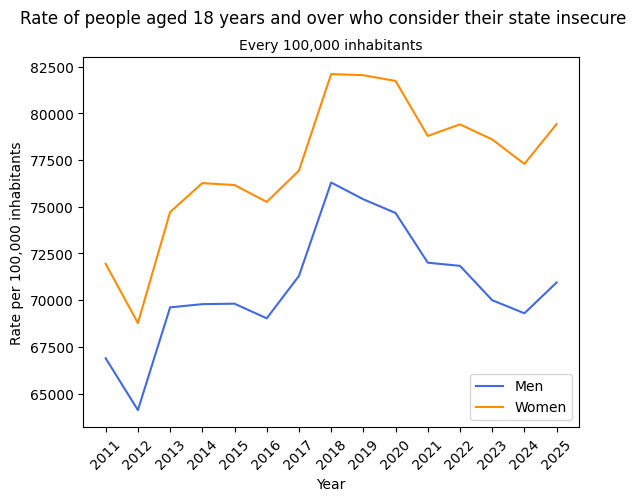

In [33]:
# https://seaborn.pydata.org/generated/seaborn.lineplot.html
sns.lineplot(x = data_by_gender.index, y = data_by_gender['Men'], color = 'royalblue', label = 'Men')

sns.lineplot(x = data_by_gender.index, y = data_by_gender['Women'], color = 'darkorange', label = 'Women')

plt.legend(loc = 'lower right')
plt.xlabel('Year')
plt.ylabel('Rate per 100,000 inhabitants')
plt.xticks(rotation=45)
plt.title('Every 100,000 inhabitants', size = 10)
# https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.suptitle.html
plt.suptitle('Rate of people aged 18 years and over who consider their state insecure', size = 12)

plt.show()

[add comment here]

- idea: create 2 subplots to compare state vs neighboorhood / municipality. 

### 3.2 People who consider their state unsafe, by state 

## 4. Conclusion

## End